# House price prediction

The dataset for this project consists of property data from Melbourne.  
The features are a mix of continuous and categorical variables.  
The task is to predict which price class a property in the city belongs to.

### Imports

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [2]:
raw_df = pd.read_csv('data/train.csv', index_col=0)

### Data exploration and visualisation

Let's look at the shape of the data.

In [3]:
print(f'Shape of the dataset: {raw_df.shape}.')

Shape of the dataset: (11543, 15).


Let's have a look at the dataset.

In [4]:
raw_df.head()

,Rooms,Type,Method,Distance,Postcode,Bedrooms,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount,Price class
0,4,h,S,6.4,3011.0,3.0,1.0,2.0,411.0,NaN,-37.79690,144.90490,Western Metropolitan,7570.0,1
1,4,h,S,14.6,3189.0,4.0,1.0,2.0,638.0,1972.0,-37.93780,145.05700,Southern Metropolitan,2555.0,1
2,5,h,PI,12.4,3107.0,5.0,4.0,2.0,968.0,1970.0,-37.77083,145.11516,Eastern Metropolitan,5420.0,1
3,3,h,SP,5.2,3056.0,3.0,1.0,2.0,264.0,NaN,-37.76110,144.96440,Northern Metropolitan,11918.0,0
4,3,h,S,8.8,3072.0,3.0,1.0,2.0,610.0,NaN,-37.75100,145.01970,Northern Metropolitan,14577.0,0


We see that the following features are strings: Type, Method and Regionname.  
We need to encode these features.

Let's check what types of data we have.

In [5]:
raw_df.dtypes

Rooms              int64
Type              object
Method            object
Distance         float64
Postcode         float64
Bedrooms         float64
Bathroom         float64
Car              float64
Landsize         float64
YearBuilt        float64
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
Price class        int64
dtype: object

Most of the features are floats.  
Number of rooms in a house is an integer.  
And the target feature is an integer.

Let's check for missing data.

In [6]:
raw_df.isna().sum()

Rooms               0
Type                0
Method              0
Distance            0
Postcode            0
Bedrooms            0
Bathroom           46
Car                53
Landsize           33
YearBuilt        4572
Lattitude           0
Longtitude          0
Regionname          0
Propertycount      40
Price class         0
dtype: int64

We see that we have missing data in the following features: Bathroom, Car, Landside, YearBuilt and Propertycount.  
This must be dealt with.

Let's see how many different categories we have in the target feature.

In [7]:
raw_df['Price class'].nunique()

3

The target feature has 3 different categories.  
Let's look at what those 3 labels are.

In [8]:
raw_df['Price class'].unique()

array([1, 0, 2], dtype=int64)

The three labels in the target are the following integers: 0, 1, and 2.

### Data cleaning

First we will encode the features that are strings.

In [9]:
# We will use OneHotEncoder from scikitlearn to encode the string features.
def encoding(x):
    ohe = OneHotEncoder()
    ohe_results = ohe.fit_transform(raw_df[[x]])
    return pd.DataFrame(ohe_results.toarray(), columns=ohe.categories_[0])

# Type, Method and Regionname features need to be encoded
typ = encoding('Type')
method = encoding('Method')
region = encoding('Regionname')

# Add the encoded features
encoded_df = raw_df.join(pd.DataFrame(typ))
encoded_df = encoded_df.join(pd.DataFrame(method))
encoded_df = encoded_df.join(pd.DataFrame(region))

# Remove the original features containing strings
del encoded_df['Type']
del encoded_df['Method']
del encoded_df['Regionname']

Let's move price class, the target feature, to the end of the dataframe for convenience

In [10]:
price = encoded_df.pop('Price class')
encoded_df['Price class'] = price
encoded_df.head()

,Rooms,Distance,Postcode,Bedrooms,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,...,VB,Eastern Metropolitan,Eastern Victoria,Northern Metropolitan,Northern Victoria,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan,Western Victoria,Price class
0,4,6.4,3011.0,3.0,1.0,2.0,411.0,NaN,-37.79690,144.90490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,4,14.6,3189.0,4.0,1.0,2.0,638.0,1972.0,-37.93780,145.05700,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,5,12.4,3107.0,5.0,4.0,2.0,968.0,1970.0,-37.77083,145.11516,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,3,5.2,3056.0,3.0,1.0,2.0,264.0,NaN,-37.76110,144.96440,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,3,8.8,3072.0,3.0,1.0,2.0,610.0,NaN,-37.75100,145.01970,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


Now we will deal with the missing data.  
First, we will try to remove the obervations with missing data.

In [11]:
nonan_df = encoded_df.dropna(axis=0)

In [13]:
lost_rows = encoded_df.shape[0] - nonan_df.shape[0]
print(f'Out of {raw_df.shape[0]} observations we lost {lost_rows} observations')

Out of 11543 observations we lost 4676 observations


Removing the observations with missing data caused us to lose almost half of the data, which is too much.  
We will try to replace the missing data with the mean value of the repective feature.

In [14]:
# We will use SimpleImputer scikitlearn to replace the missing data with mean values
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(encoded_df.values)
imputed_data = imr.transform(encoded_df.values)
imputed_df = pd.DataFrame(imr.fit_transform(encoded_df))
colnames = list(encoded_df.columns.values)
imputed_df = imputed_df.set_axis(colnames, axis=1, inplace=False)

Let's look at some basic statistics

In [15]:
imputed_df.describe()

,Rooms,Distance,Postcode,Bedrooms,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,...,VB,Eastern Metropolitan,Eastern Victoria,Northern Metropolitan,Northern Victoria,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan,Western Victoria,Price class
count,11543.000000,11543.000000,11543.000000,11543.000000,11543.00000,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,...,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000
mean,2.944122,10.158694,3105.288400,2.921164,1.53527,1.614534,531.192789,1964.764596,-37.809255,144.995236,...,0.088192,0.108637,0.003812,0.285541,0.003119,0.033440,0.345491,0.217448,0.002512,0.438794
std,0.953200,5.864749,90.169874,0.966528,0.69143,0.956776,1536.529369,29.099193,0.079379,0.104103,...,0.283586,0.311197,0.061625,0.451691,0.055761,0.179791,0.475549,0.412528,0.050062,0.607847
min,1.000000,0.000000,3000.000000,0.000000,0.00000,0.000000,0.000000,1196.000000,-38.182550,144.431810,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.200000,3044.000000,2.000000,1.00000,1.000000,180.000000,1960.000000,-37.857100,144.929500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,9.200000,3084.000000,3.000000,1.00000,2.000000,445.000000,1964.764596,-37.802300,145.000150,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,13.000000,3148.000000,3.000000,2.00000,2.000000,650.000000,1975.000000,-37.756250,145.058200,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,10.000000,48.100000,3977.000000,20.000000,8.00000,10.000000,76000.000000,2018.000000,-37.408530,145.526350,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


The standard deviation of Landsize is very large, about 3 times as large as the mean. Which is something we will have to deal with.

### Visualization

Let's make some visualisations to look at the distribution of the features.

First we will look at a histogram for the non-dummy features (including the dummies results in plots that are not very nice).

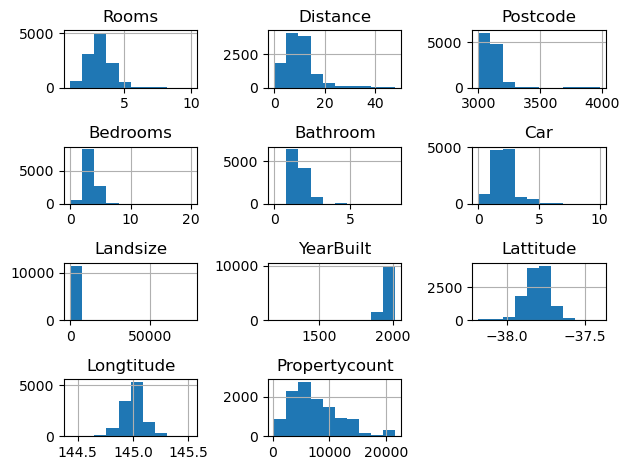

In [17]:
imputed_df.iloc[:,:11].hist()
plt.tight_layout()
plt.show()

Looks like there are some positive outliers in number of rooms, distance, postcode, bedrooms, bathrooms, car(parking spots), landsize and property count, while year built have some negative outliers